# Question 3 (privacy with local differential privacy)

1. We consider `Age` and `Sex` as sensitive attributes.
2. We reconstruct the original `Sex` column (which was dropped in the processed dataset) by merging it from the raw `adult.data` file.
3. We:
   - Create an `AgeGroup` (age ranges) and compute the **true cross-tabulation** `AgeGroup × Sex`.
   - Apply **local differential privacy (LDP)** using randomized response on `AgeGroup` and `Sex` to obtain a **private dataset**.
   - Compute a **cross-tabulation on the private data**, and quantify the **estimation error** compared to the true table.
4. We build two classifiers:
   - A **baseline classifier** using the original (non-private) data.
   - A **private classifier** where `Age` and `Sex` are replaced by their privatized versions.
5. We compare the performance of the private classifier to the baseline to see the **impact of privacy on model performance**.


In [31]:
#  Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

np.random.seed(42)


In [34]:
# Loading processed dataset and raw dataset, re-adding Sex column

# 2.1 Loading the processed dataset  (same as for Q1 and Q2)
df_proc = pd.read_csv("adult_processed.csv")
print("Processed shape:", df_proc.shape)
print("First 10 columns of processed df:", df_proc.columns[:10])

# 2.2 Loading the original raw adult dataset to recover 'Sex'
raw_cols = [
    "Age","Workclass","fnlwgt","Education","Education-Num","MaritalStatus",
    "Occupation","Relationship","Race","Sex","CapitalGain","CapitalLoss",
    "HoursPerWeek","NativeCountry","Income"
]

df_raw = pd.read_csv("adult.data", names=raw_cols, skipinitialspace=True)
print("Raw shape:", df_raw.shape)
print("Raw columns:", df_raw.columns)

# 2.3 Quick alignment check
assert len(df_proc) == len(df_raw), "Processed and raw datasets have different number of rows!"

# 2.4 Re-adding Sex column (same format as original) into processed df
df_proc["Sex"] = df_raw["Sex"].values

# 2.5 Quick check
print("\nProcessed df with Sex re-added:")
print(df_proc[["Age", "Sex"]].head())


Processed shape: (32561, 102)
First 10 columns of processed df: Index(['Age', 'fnlwgt', 'Education-Num', 'Capital Gain', 'Capital Loss',
       'Hours per week', 'age_binary', 'Workclass_ Federal-gov',
       'Workclass_ Local-gov', 'Workclass_ Never-worked'],
      dtype='object')
Raw shape: (32561, 15)
Raw columns: Index(['Age', 'Workclass', 'fnlwgt', 'Education', 'Education-Num',
       'MaritalStatus', 'Occupation', 'Relationship', 'Race', 'Sex',
       'CapitalGain', 'CapitalLoss', 'HoursPerWeek', 'NativeCountry',
       'Income'],
      dtype='object')

Processed df with Sex re-added:
   Age     Sex
0   39    Male
1   50    Male
2   38    Male
3   53    Male
4   28  Female


In [35]:
# Building AgeGroup and select Age & Sex for the privacy analysis

df_q3 = df_proc.copy()

# 3.1 Defining age groups 
bins = [0, 30, 40, 50, 100]
labels = ["<=30", "31-40", "41-50", "51+"]

df_q3["AgeGroup"] = pd.cut(df_q3["Age"], bins=bins, labels=labels, right=True, include_lowest=True)

# 3.2 Keeping only the columns we need for the LDP analysis
df_ldp = df_q3[["AgeGroup", "Sex"]].copy()

print("Unique AgeGroups:", df_ldp["AgeGroup"].unique())
print("Unique Sex values:", df_ldp["Sex"].unique())

df_ldp.head()


Unique AgeGroups: ['31-40', '41-50', '51+', '<=30']
Categories (4, object): ['<=30' < '31-40' < '41-50' < '51+']
Unique Sex values: ['Male' 'Female']


,AgeGroup,Sex
0,31-40,Male
1,41-50,Male
2,31-40,Male
3,51+,Male
4,<=30,Female


True cross-tab AgeGroup × Sex:
Sex       Female  Male
AgeGroup              
<=30        4259  6313
31-40       2566  5980
41-50       2054  4929
51+         1892  4568


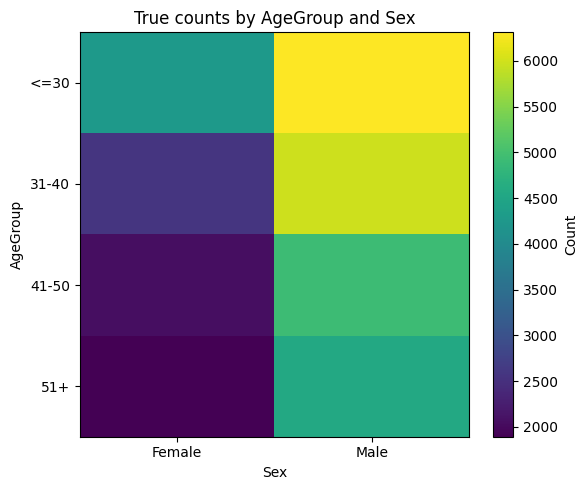

In [36]:
# True cross-tab of AgeGroup × Sex

true_crosstab = pd.crosstab(df_ldp["AgeGroup"], df_ldp["Sex"])
print("True cross-tab AgeGroup × Sex:")
print(true_crosstab)

# Heatmap for the true crosstab
plt.figure(figsize=(6, 5))
plt.imshow(true_crosstab.values, aspect="auto")
plt.xticks(range(len(true_crosstab.columns)), true_crosstab.columns)
plt.yticks(range(len(true_crosstab.index)), true_crosstab.index)
plt.colorbar(label="Count")
plt.title("True counts by AgeGroup and Sex")
plt.xlabel("Sex")
plt.ylabel("AgeGroup")
plt.tight_layout()
plt.show()


In [37]:
#  Helper functions for Local Differential Privacy (randomized response)

def randomized_response(values, epsilon, categories):
    """
    Apply k-ary randomized response to a 1D array of categorical values.
    values: pandas Series or list of true categories
    epsilon: privacy parameter
    categories: list of all possible categories (strings)
    Returns: numpy array of noisy categories
    """
    values = pd.Series(values)
    n = len(values)
    k = len(categories)
    
    p = np.exp(epsilon) / (np.exp(epsilon) + k - 1)  # prob of keeping true value
    q = (1 - p) / (k - 1)                            # prob of each wrong category
    
    noisy = []
    for v in values:
        if v not in categories or pd.isna(v):
            # If unknown/missing, just sample from prior
            noisy.append(np.random.choice(categories))
            continue
        if np.random.rand() < p:
            noisy.append(v)
        else:
            # sampling any other category
            others = [c for c in categories if c != v]
            noisy.append(np.random.choice(others))
    return np.array(noisy)


In [38]:
#  Applying LDP to AgeGroup and Sex to create private dataset

epsilon = 1.0   # we can try 0.1, 0.5, 1.0, 2.0 later

age_categories = list(df_ldp["AgeGroup"].dropna().unique())
sex_categories = list(df_ldp["Sex"].dropna().unique())

print("Age categories for LDP:", age_categories)
print("Sex categories for LDP:", sex_categories)

df_ldp["AgeGroup_noisy"] = randomized_response(df_ldp["AgeGroup"], epsilon, age_categories)
df_ldp["Sex_noisy"] = randomized_response(df_ldp["Sex"], epsilon, sex_categories)

df_ldp.head()


Age categories for LDP: ['31-40', '41-50', '51+', '<=30']
Sex categories for LDP: ['Male', 'Female']


,AgeGroup,Sex,AgeGroup_noisy,Sex_noisy
0,31-40,Male,31-40,Male
1,41-50,Male,<=30,Male
2,31-40,Male,41-50,Male
3,51+,Male,51+,Male
4,<=30,Female,<=30,Male


Noisy cross-tab (LDP) AgeGroup_noisy × Sex_noisy:
Sex_noisy       Female  Male
AgeGroup_noisy              
31-40             3471  4918
41-50             3260  4472
51+               3184  4432
<=30              3833  4991

Aligned true table:
Sex       Male  Female
AgeGroup              
31-40     5980    2566
41-50     4929    2054
51+       4568    1892
<=30      6313    4259

Aligned noisy table:
Sex_noisy       Male  Female
AgeGroup_noisy              
31-40           4918    3471
41-50           4472    3260
51+             4432    3184
<=30            4991    3833

Absolute error per cell:
Sex_noisy       Male  Female
AgeGroup_noisy              
31-40           1062     905
41-50            457    1206
51+              136    1292
<=30            1322     426

Squared error per cell:
Sex_noisy          Male   Female
AgeGroup_noisy                  
31-40           1127844   819025
41-50            208849  1454436
51+               18496  1669264
<=30            1747684   18147

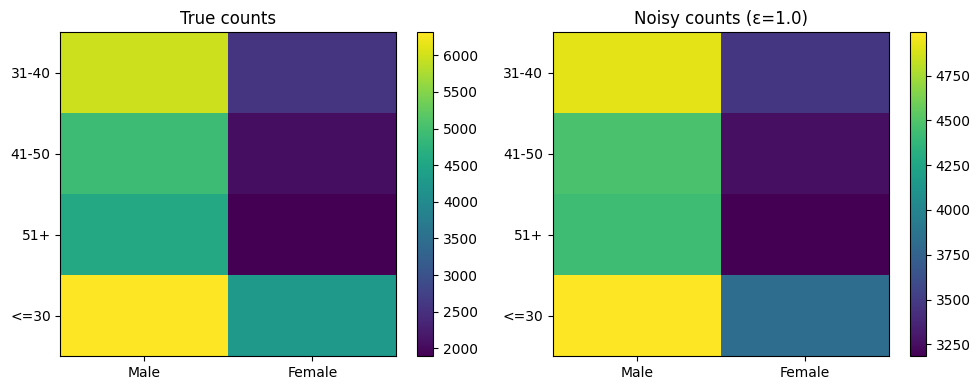

In [39]:
#  Cross-tab on noisy data and error metrics

# 7.1 Noisy cross-tab
noisy_crosstab = pd.crosstab(df_ldp["AgeGroup_noisy"], df_ldp["Sex_noisy"])
print("Noisy cross-tab (LDP) AgeGroup_noisy × Sex_noisy:")
print(noisy_crosstab)

# 7.2 Aligning tables so they have the same index/columns order
true_table = true_crosstab.reindex(index=age_categories, columns=sex_categories, fill_value=0)
noisy_table = noisy_crosstab.reindex(index=age_categories, columns=sex_categories, fill_value=0)

print("\nAligned true table:")
print(true_table)
print("\nAligned noisy table:")
print(noisy_table)

# 7.3 Error metrics
abs_error = (noisy_table - true_table).abs()
sq_error = (noisy_table - true_table) ** 2

print("\nAbsolute error per cell:")
print(abs_error)

print("\nSquared error per cell:")
print(sq_error)

print("\nTotal absolute error:", abs_error.values.sum())
print("Total squared error:", sq_error.values.sum())

# 7.4 Visual comparison
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

im0 = axes[0].imshow(true_table.values, aspect="auto")
axes[0].set_title("True counts")
axes[0].set_xticks(range(len(true_table.columns)))
axes[0].set_xticklabels(true_table.columns)
axes[0].set_yticks(range(len(true_table.index)))
axes[0].set_yticklabels(true_table.index)
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(noisy_table.values, aspect="auto")
axes[1].set_title(f"Noisy counts (ε={epsilon})")
axes[1].set_xticks(range(len(noisy_table.columns)))
axes[1].set_xticklabels(noisy_table.columns)
axes[1].set_yticks(range(len(noisy_table.index)))
axes[1].set_yticklabels(noisy_table.index)
plt.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()


In [40]:
#  Preparing Q3 classification datasets

df_clf = df_proc.copy()

# 8.1 Re-adding Sex (already done, but we ensure it's there)
df_clf["Sex"] = df_raw["Sex"].values

# 8.2 AgeGroup (same as before ((useful later if needed)
df_clf["AgeGroup"] = pd.cut(df_clf["Age"], bins=bins, labels=labels, right=True, include_lowest=True)

# 8.3 Binary Sex feature for baseline classifier
df_clf["Sex_Male"] = (df_clf["Sex"].str.strip() == "Male").astype(int)

# 8.4 Attaching LDP noisy columns (AgeGroup_noisy, Sex_noisy) by index
df_clf["AgeGroup_noisy"] = df_ldp["AgeGroup_noisy"].values
df_clf["Sex_noisy"] = df_ldp["Sex_noisy"].values

# 8.5 Creating numeric privatized features:
# - Sex_priv_Male: from Sex_noisy
# - Age_priv: numeric approximation from AgeGroup_noisy (midpoints of bins)

age_mid = {
    "<=30": 25,
    "31-40": 35,
    "41-50": 45,
    "51+": 60
}

df_clf["Sex_priv_Male"] = (df_clf["Sex_noisy"].str.strip() == "Male").astype(int)
df_clf["Age_priv"] = df_clf["AgeGroup_noisy"].map(age_mid).astype(float)

# 8.6 Target variable
y = df_clf["Target"]

print("df_clf columns (subset):", df_clf[["Age", "Sex", "Sex_Male", "Age_priv", "Sex_priv_Male", "Target"]].head())


df_clf columns (subset):    Age     Sex  Sex_Male  Age_priv  Sex_priv_Male  Target
0   39    Male         1      35.0              1       0
1   50    Male         1      25.0              1       0
2   38    Male         1      45.0              1       0
3   53    Male         1      60.0              1       0
4   28  Female         0      25.0              1       0


In [41]:
# Building feature matrices for baseline and private classifiers

# 9.1 Baseline features: numeric columns only
X_base = df_clf.select_dtypes(include=[np.number]).copy()

X_base_baseline = X_base.drop(columns=["Age_priv", "Sex_priv_Male"], errors="ignore")

# Dropping target from X
X_base_baseline = X_base_baseline.drop(columns=["Target"], errors="ignore")

print("Baseline X shape:", X_base_baseline.shape)

# 9.2 Private features:
# We take numeric columns, but now we **drop true Age and Sex_Male** and keep Age_priv / Sex_priv_Male
X_priv = df_clf.select_dtypes(include=[np.number]).copy()

X_priv_private = X_priv.drop(
    columns=["Age", "Sex_Male"],  # drop true sensitive features
    errors="ignore"
)

# Dropping Target from features
X_priv_private = X_priv_private.drop(columns=["Target"], errors="ignore")

print("Private X shape:", X_priv_private.shape)


Baseline X shape: (32561, 8)
Private X shape: (32561, 8)


In [42]:
#  Train/test split and baseline classifier

X_train_b, X_test_b, y_train, y_test = train_test_split(
    X_base_baseline, y, test_size=0.2, random_state=42, stratify=y
)

clf_base = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

clf_base.fit(X_train_b, y_train)
y_pred_b = clf_base.predict(X_test_b)

print("Baseline accuracy:", accuracy_score(y_test, y_pred_b))
print("Baseline F1-score:", f1_score(y_test, y_pred_b, average="weighted"))


Baseline accuracy: 0.8160601873176724
Baseline F1-score: 0.810412300879009


In [43]:
# Private classifier using Age_priv and Sex_priv_Male

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(
    X_priv_private, y, test_size=0.2, random_state=42, stratify=y
)

clf_priv = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

clf_priv.fit(X_train_p, y_train_p)
y_pred_p = clf_priv.predict(X_test_p)

print("Private accuracy:", accuracy_score(y_test_p, y_pred_p))
print("Private F1-score:", f1_score(y_test_p, y_pred_p, average="weighted"))


Private accuracy: 0.7941040994933211
Private F1-score: 0.7893233807363365
